# Sistema de detección de enlaces spam
- El objetivo será implementar un sistema que sea capaz de detectar automáticamente si una página web contiene spam o no basándonos en su URL.

### Carga de datos
- Cargo la base de datos .csv utilizando pandas

In [16]:
import pandas as pd

total_data = pd.read_csv('https://breathecode.herokuapp.com/asset/internal-link?id=932&path=url_spam.csv')
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


### Procesamiento de datos


In [17]:
# Convertimos la columna categórica/booleana a numérica (True=1, False=0)
total_data["is_spam"] = total_data["is_spam"].apply(lambda x: 1 if x == True else 0)

# Verificamos el balance de clases
print(total_data["is_spam"].value_counts())

is_spam
0    2303
1     696
Name: count, dtype: int64


Dado que una pagina web tiene otro tipo de caracteres (a diferencia del correo como se vio en la lectura de la academia), utilizaré otro tipo de preprocesado para separar palabras claras como "google, login, free etc."

Visualización de la distribución de clases
- Es importante ver qué tan desbalanceado está el dataset.

C:\Users\asjer\AppData\Local\Temp\ipykernel_18552\1156222281.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_spam', data=total_data, palette="Set2")


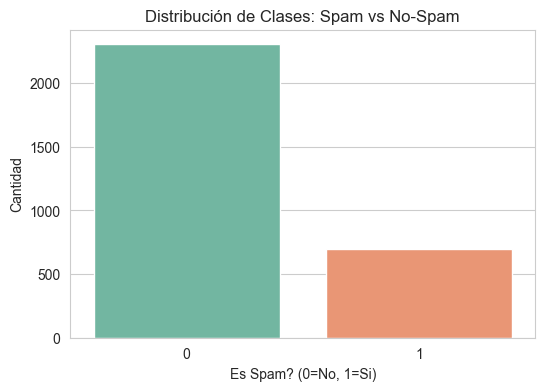

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x='is_spam', data=total_data, palette="Set2")
plt.title('Distribución de Clases: Spam vs No-Spam')
plt.xlabel('Es Spam? (0=No, 1=Si)')
plt.ylabel('Cantidad')
plt.savefig('../reports/figures/class_balance.png')
plt.show()


**Interpretación de grafico**
- El grafico es simple nos muestra la distribución de las clases, donde podemos observar que el dataset esta desbalanceado, lo que indica que hay una gran cantidad de datos de no spam y una menor cantidad de datos de spam.

### Limpieza de datos


In [19]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import os

nltk_data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'nltk_data'))
nltk.download('stopwords')
nltk.download('wordnet')
if nltk_data_path not in nltk.data.path:
    nltk.data.path.append(nltk_data_path)


stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def preprocess_url(url):
    # 1. Eliminar prefijos de protocolo (https://, www.) para dejar solo el contenido
    url = re.sub(r'https?://(www\.)?', '', url)

    # 2. Dividir la URL por caracteres especiales (puntos, guiones, barras, etc.)
    tokens = re.split(r'[./\-_?=&]', url)

    # 3. Eliminar tokens vacíos o espacios
    tokens = [token for token in tokens if token]

    # 4. Lematización y eliminación de stopwords
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(processed_tokens)

# Aplicamos la transformación
# Asumo que 'total_data' está definido en una celda anterior
total_data["url_cleaned"] = total_data["url"].apply(preprocess_url)

print(total_data[["url", "url_cleaned"]].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asjer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asjer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                 url  \
0  https://briefingday.us8.list-manage.com/unsubs...   
1                             https://www.hvper.com/   
2                 https://briefingday.com/m/v4n3i4f3   
3   https://briefingday.com/n/20200618/m#commentform   
4                        https://briefingday.com/fan   

                                   url_cleaned  
0  briefingday us8 list manage com unsubscribe  
1                                    hvper com  
2                     briefingday com v4n3i4f3  
3     briefingday com n 20200618 m#commentform  
4                          briefingday com fan  


### Grafico WordCloud
- Este grafico nos muestra los terminos mas frecuentes en URLs de Spam vs Legítimas.

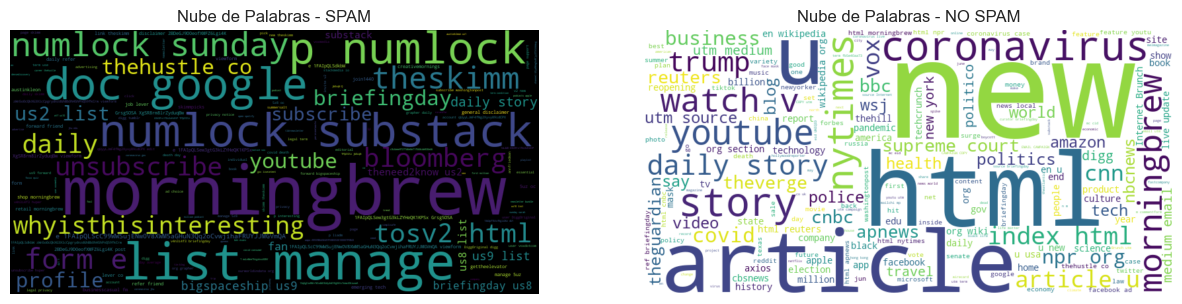

In [20]:
from wordcloud import WordCloud
# Separar URLs de spam y no spam
spam_text = " ".join(total_data[total_data['is_spam'] == 1]['url_cleaned'])
non_spam_text = " ".join(total_data[total_data['is_spam'] == 0]['url_cleaned'])

# Generar nubes de palabras
wordcloud_spam = WordCloud(width=800, height=400, background_color='black').generate(spam_text)
wordcloud_non_spam = WordCloud(width=800, height=400, background_color='white').generate(non_spam_text)

# Graficar
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - SPAM')
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - NO SPAM')
plt.savefig('../reports/figures/wordcloud_spam.png')
plt.show()

In [21]:
**El grafico muestra las palabras mas comunes que encontro las urls de spam y no spam**

SyntaxError: invalid syntax (2547388945.py, line 1)

### Dividir el dataset en train y test
- Paso crucial para poder entrenar y evaluar un modelo.

In [ ]:
# Vectorización (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)
X = vectorizer.fit_transform(total_data["url_cleaned"]).toarray()
y = total_data["is_spam"]

# División en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

NameError: name 'TfidfVectorizer' is not defined

### Construyendo modelo SVM
- De momento entrenare un modelo con los parametros por defecto solamente utilizando la semilla randomstate 42

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Inicialización con parámetros por defecto
model = SVC(random_state=42)
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

# Evaluación inicial
print(f"Accuracy base: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy base: 0.9466666666666667
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       455
           1       0.94      0.83      0.88       145

    accuracy                           0.95       600
   macro avg       0.95      0.91      0.92       600
weighted avg       0.95      0.95      0.95       600



### Optimizacion del modelo (hiperparametros)
- Aquí usare GridSearchCV.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definimos la cuadrícula de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'] # Relevante para kernel rbf
}

grid_search = GridSearchCV(estimator=SVC(random_state=42), param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f"Mejores parámetros encontrados: {grid_search.best_params_}")
print(f"Mejor puntuación (accuracy): {grid_search.best_score_}")

# Guardamos el mejor modelo en una variable
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores parámetros encontrados: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor puntuación (accuracy): 0.9549874843554443


### Visualizacion del rendimiento (Matriz de confusión)
- Evaluaremos el rendimiento final optimizado de nuestro modelo.

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predecir con el mejor modelo
y_pred_best = best_model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Spam", "Spam"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión (SVC)")
plt.savefig("../reports/figures/matriz_confusion_svm.png")
plt.show()

NameError: name 'best_model' is not defined

### Guardado del modelo
- Utilizando la libreria pickle, guardare el modelo como svm_url_spam.pkl

In [ ]:
from pickle import dump

# Guardamos el modelo optimizado
dump(best_model, open("../models/svm_url_spam_optimized.sav", "wb"))
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.
